## Train Manipulations ##

In [451]:
classes = {'стояние' : 0, 'стою' : 0, 'месте' : 0, 'stoyat' : 0, 'покой' : 0,
           'ходьба' : 1, 'go' : 1, 'walk' : 1, 'шаг' : 1,
           'бег' : 2, 'run' : 2,
           'велосипед' : 3,
           'лестниц' : 4, 'подъ' : 4, 'stairs' : 4, 'вверх' : 4,
           'автомобил' : 5, 'машин' : 5, "авто пасс" : 5,
           'метро' : 6, 'электричк' : 6,
           'электросамокат' : 7,
           'самокат' : 8}

answers = {0 : 'Стояние', 1 : 'Ходьба', 2 : 'Бег', 3 : 'Велосипед', 4 : 'Лестница', 
           5 : 'Автомобиль', 6 : 'Метро', 7 : 'Электросамокат', 8 : 'Самокат'}

def parsing(filename):
    for act in classes:
        if filename.lower().find(act) != -1:
            return classes[act]
    return -1

In [452]:
import numpy as np

def rotation_matrix(vec1):
    b = np.array([0, 0, -1])
    # Нормировка
    a = (vec1 / np.linalg.norm(vec1)).reshape(3)
    v = np.cross(a, b) # векторное произведение
    
    if any(v):
        c = a * b
        s = np.linalg.norm(v)
        # https://ru.wikipedia.org/wiki/Векторное_произведение#Преобразование_к_матричной_форме        
        kmat = np.array([ [0, -v[2], v[1]],
                          [v[2], 0, -v[0]],
                          [-v[1], v[0], 0]
                        ])

        return np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))

    else:
        return numpy.eye(3)
    
def rotate(df, mat):
    new_x = []
    new_y = []
    new_z = []
    
    for elem in zip(df.gFx.tolist(), df.gFy.tolist(), df.gFz.tolist()):
        res = mat @ elem
        new_x.append(res[0])
        new_y.append(res[1])
        new_z.append(res[2])
        
    return new_x, new_y, new_z

In [453]:
import pandas as pd
from datetime import datetime

def integrate(Acc_arr):
    sm_arr = np.cumsum(Acc_arr).tolist()
    return np.array(sm_arr), sm_arr[-1]

class Track:
    def __init__(self, df, target, a=None, b=None, cut=True):
        self.level = None
        self.Name = target
        # Средняя частота сбора данных
        self.Freq = 0.0
        self.Time = 0.0
        self.TimeUncut = 0.0
        try:
            df[df.columns[0]] = df[df.columns[0]].astype(float)
            self.Time = (df[df.columns[0]][df.shape[0]-2] - df[df.columns[0]][1])
            self.Freq = round( (df.shape[0] - 2) / self.Time )
        except:
            tmd = [ datetime.strptime(df[df.columns[0]][i], "%Y-%m-%d %H:%M:%S.%f") 
                  for i in range(df.shape[0]) ]
            
            tm = []
            for i in range(len(tmd)):
                tm.append((tmd[i] - tmd[0]).total_seconds())
            self.Time = (tm[-2] - tm[1])
            self.Freq = round( (df.shape[0] - 2) / self.Time )
            df[df.columns[0]] = tm

        self.TimeUncut = self.Time
        # Обрезка
        if self.TimeUncut > 25:
            if cut != False:
                if a == None:
                    st = round(self.Freq * 9)
                else:
                    st = round(self.Freq * a)
            
                if b == None:
                    end = round(df.shape[0] - self.Freq * 9)
                else:
                    end = round(df.shape[0] - self.Freq * b)
                
                self.df = df.truncate(before=st, after=end - 1, copy=True)
            else:
                self.df = df
        elif self.TimeUncut > 20:
            if cut != False:
                if a == None:
                    st = round(self.Freq * 7)
                else:
                    st = round(self.Freq * a)
            
                if b == None:
                    end = round(df.shape[0] - self.Freq * 7)
                else:
                    end = round(df.shape[0] - self.Freq * b)
                
                self.df = df.truncate(before=st, after=end - 1, copy=True)
            else:
                self.df = df
        else:
                self.df = df

        # Вставим в таблицу столбец с нормой ускорения
        column_values = pd.Series( (df.gFx ** 2 + df.gFy ** 2 + df.gFz ** 2) ** 0.5 )
        self.df.insert(loc=0, column='AbsAcc', value=column_values)
        
        self.Ampl = self.df.AbsAcc.max() - self.df.AbsAcc.min()
        # Среднее по модулю ускорения
        self.Mean = self.df.AbsAcc.mean()

        # Выборочная дисперсия
        self.Var = 0.0
        for row in self.df.itertuples():
            self.Var += (row.AbsAcc - self.Mean) ** 2
        self.Var /= (self.df.shape[0] - 1)
        
        # FFT # -- еще найти пик и значение, на котором он достигается
        n = self.df.shape[0]
        k = np.arange(n)
        frq = k * self.Freq / n
        frq = frq[:len(frq) // 2]
        
        # X
        y = self.df.gFx.tolist()
        Y = np.fft.fft(y) / n
        Y = Y[:n // 2]
    
        yabs = abs(Y)
        self.frq = frq
        self.yabsX = yabs
        
        # Y
        y = self.df.gFy.tolist()
        Y = np.fft.fft(y) / n
        Y = Y[:n // 2]
    
        yabs = abs(Y)
        self.yabsY = yabs
        
        # Z
        y = self.df.gFz.tolist()
        Y = np.fft.fft(y) / n
        Y = Y[:n // 2]
    
        yabs = abs(Y)
        self.yabsZ = yabs
        
        # Norm
        y = self.df.AbsAcc.tolist()
        Y = np.fft.fft(y) / n
        Y = Y[:n // 2]
    
        yabs = abs(Y)
        self.yabsN = yabs
        
        # Узнаем точки пика
        self.PeakX = 0
        self.PeakY = 0
        self.PeakZ = 0
        self.PeakN = 0
        vX, vY, vZ, vN = 0, 0, 0, 0
        
        for i in range(1, len(frq)):
            if self.yabsX[i] > vX:
                self.PeakX = frq[i]
                vX = self.yabsX[i]
            if self.yabsY[i] > vY:
                self.PeakY = frq[i]
                vY = self.yabsY[i]
            if self.yabsZ[i] > vZ:
                self.PeakZ = frq[i]
                vZ = self.yabsZ[i]
            if self.yabsN[i] > vN:
                self.PeakN = frq[i]
                vN = self.yabsN[i]
        
        # Повращаем координаты
        acc_mean = [self.df.gFx.mean(), self.df.gFy.mean(), self.df.gFz.mean()]
        r_mat = rotation_matrix(acc_mean)
        gx, gy, gz = rotate(self.df, r_mat)
        self.df.gFx = pd.Series(gx)
        self.df.gFy = pd.Series(gy)
        self.df.gFz = pd.Series(gz)
        
        gx = [elem / self.Freq ** 2 for elem in gx]
        gy = [elem / self.Freq ** 2 for elem in gy]
        gz = [(elem + 1) / self.Freq ** 2 for elem in gz]
        
        speed_arrx, speedX = integrate(gx)
        self.MoveX, _ = integrate(speed_arrx)
        
        speed_arry, speedY = integrate(gy)
        self.MoveY, _ = integrate(speed_arry)
        
        speed_arrz, speedZ = integrate(gz)
        self.MoveZ, _ = integrate(speed_arrz)
        
        self.Speed = (speedX ** 2 + speedY ** 2 + speedZ ** 2) ** 0.5
        
    def info():
        print("Амплитуда:", self.Ampl)
        print("Среднее ускорение:", self.Mean)
        print("Медиана ускорения:", self.Median)
        print("Квантиль ускорения:", self.Quantile)
        print("Выборочная дисперсия:", self.Var)
        

In [454]:
import os

def format(df):
    df = df.applymap(lambda x: str(x).replace(',','.'))
    try:
        df['gFx'] = df['gFx'].astype(float)
        df['gFy'] = df['gFy'].astype(float)
        df['gFz'] = df['gFz'].astype(float)
    except KeyError:
        print("F")
    return df

path = r'C:\Users\Oleg\Desktop\Практика\Айпунбы\train_data' 
data = {}
Data = []

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            #print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=';')
                if df.shape[1] == 5:
                    Tr = Track(format(df), dir_entry_path.split("\\")[-1])
                    if Tr.TimeUncut > 20:
                        Data.append(Tr)
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            #print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=',')
                if df.shape[1] == 5:
                    Tr = Track(format(df), dir_entry_path.split("\\")[-1])
                    if Tr.TimeUncut > 20:
                        Data.append(Tr)
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

In [455]:
Ampl = []
for track in Data:
    # print(track.Name)
    try:
        answers[parsing(track.Name)]
    except:
        print(track.Name)
        continue
    Ampl.append(track.Ampl)
    
len(Data), len(Ampl)

(1144, 1144)

Некоторые амплитуды посчитаны некорректно, уберём соответствующие треки.

In [456]:
import math
good_indices = []
for i in range(len(Ampl)):
    if not (math.isnan(Ampl[i]) or Ampl[i]==1):
        good_indices.append(i)
    else:
        print(Data[i].Name)
GoodData = [Data[i] for i in good_indices]
GoodAmpl = [Ampl[i] for i in good_indices]

In [457]:
len(Data), len(GoodData)

(1144, 1144)

In [458]:
for i in range(len(GoodData)):
    if parsing(GoodData[i].Name) < 5:
        GoodData[i].level = 'base'
    else:
        GoodData[i].level = 'advanced'

Соберем по каждому типу движения массив DataFrame'ов и среди каждого такого массива посчитаем средние, а так же максимальные значения тех или иных характеристик.

In [459]:
from matplotlib import pylab as plt
%matplotlib inline

def draw(Track):
    if draw:
        fig, ((ax1, ax2, ax3), (ax7, ax8, ax9)) = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
        ax1.plot(Track.df['gFx'], c='g')
        ax1.plot(Track.df['gFy'], c='r')
        ax1.plot(Track.df['gFz'], c='b')
        ax2.plot(Track.df['AbsAcc'])
        
        ax3.plot(Track.frq, Track.yabsN)
        ax3.set_xlim([1, 3])
        ax3.set_ylim([0, 0.10])
        
        ax7.plot(Track.MoveX)
        ax8.plot(Track.MoveY)
        ax9.plot(Track.MoveZ)
        
        plt.show()

In [460]:
types = []
for i in range(9):
    movement_type = []
    for j in range(len(GoodData)):
        if parsing(GoodData[j].Name) == i:
            movement_type.append(GoodData[j])
    types.append(movement_type)

Kirill Dzhunkowski - 2021-07-0419.48_Dzhunkowski_ходьба.39


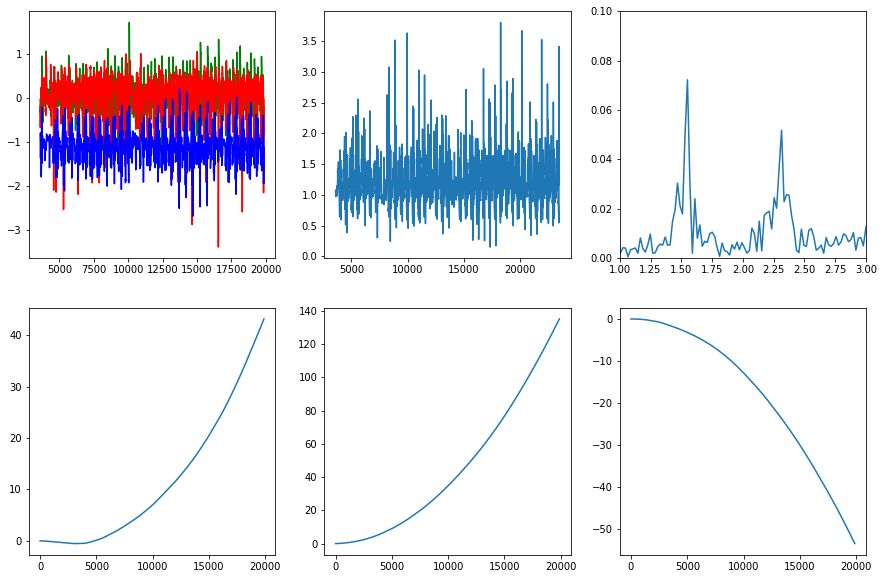

Kirill Dzhunkowski - 2021-07-0419.58.30_Dzhunkowski_ходьба


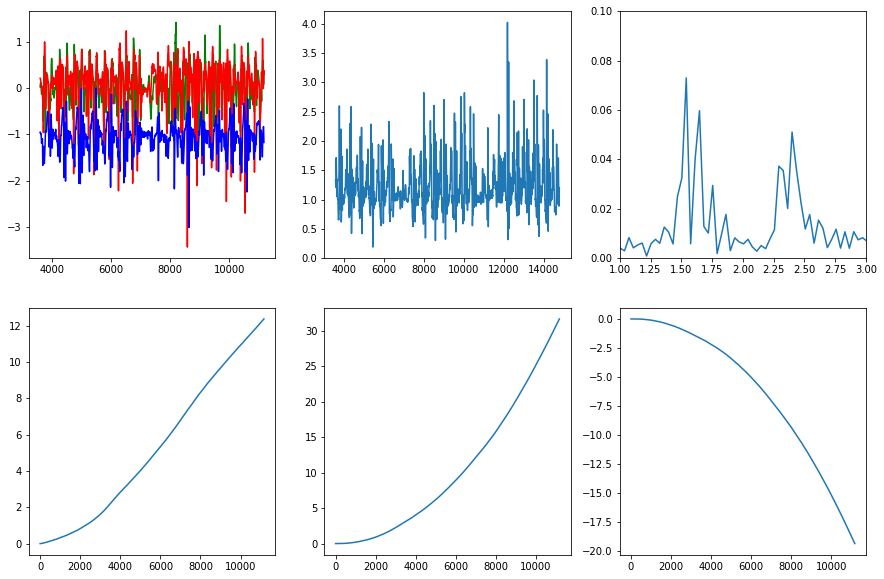

Kirill Dzhunkowski - 2021-07-0711.35.15_Dzhunkowski_ходьба


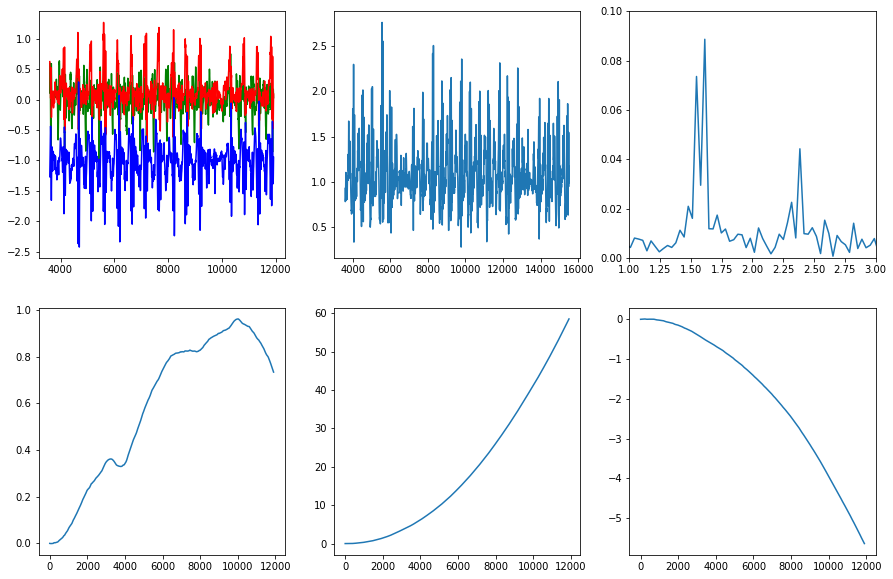

Kirill Dzhunkowski - 2021-07-0711.38.36_Dzhunkowski_ходьба


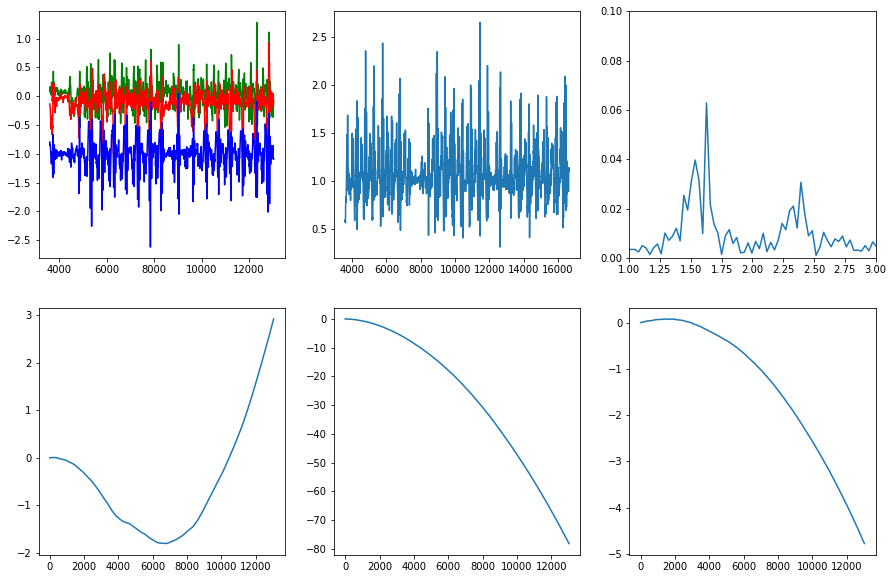

Oleg Petrov - 2021-07-0321.21.29 Петров Ходьба


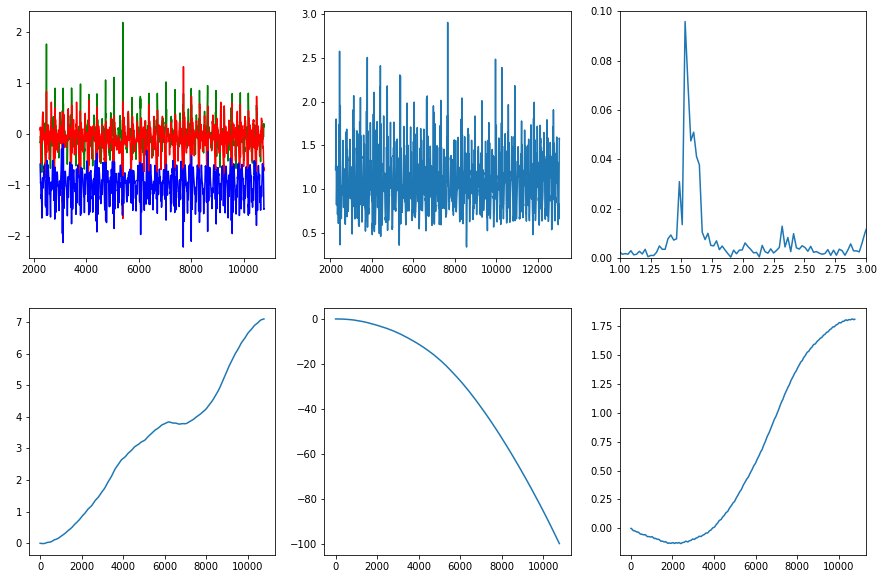

Oleg Petrov - 2021-07-0720.12.00 Петров Ходьба


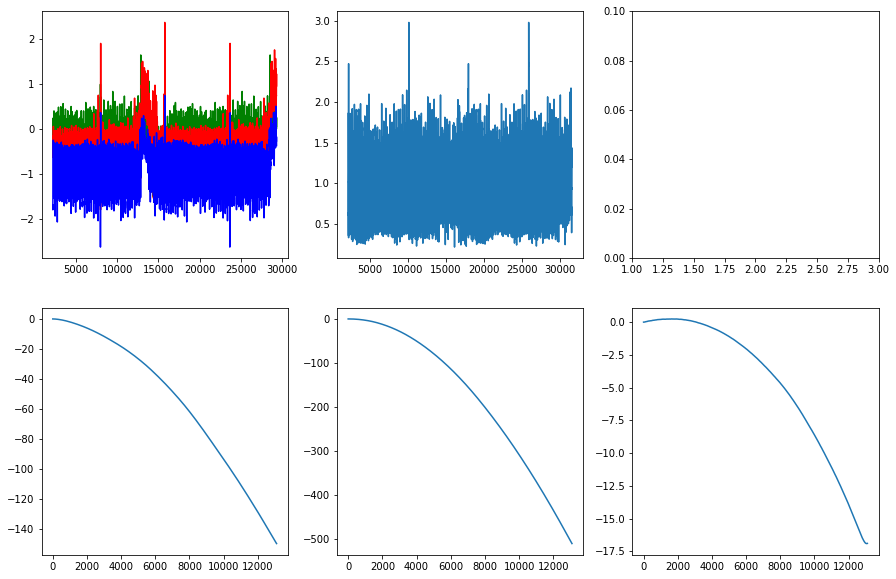

Oleg Petrov - 2021-07-0720.13.38 Петров Ходьба


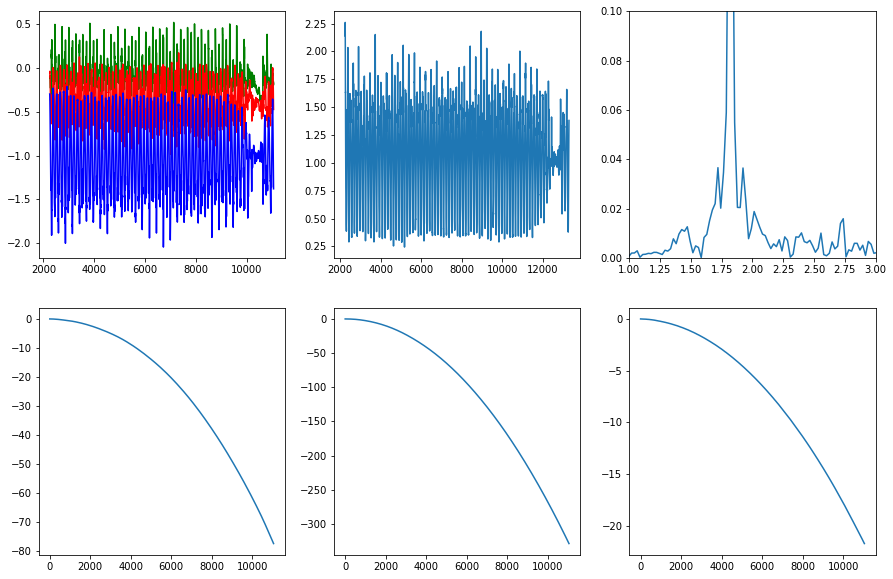

Oleg Petrov - 2021-07-0720.15.04 Петров Ходьба


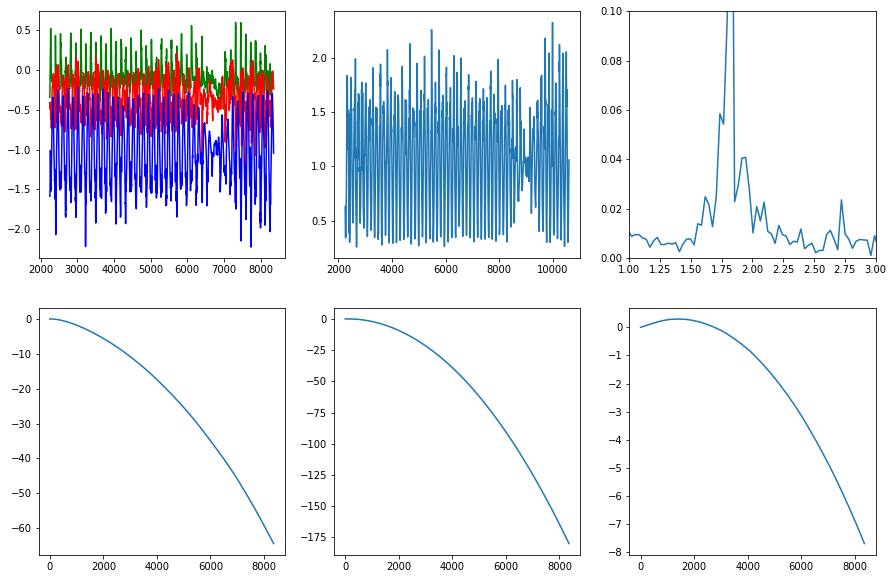

Oleg Petrov - 2021-07-0720.16.15 Петров Ходьба


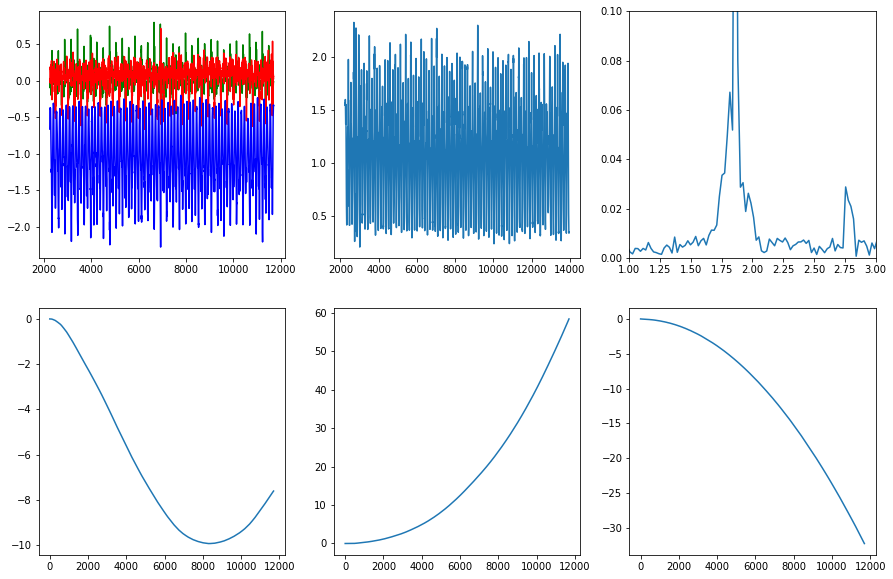

Александр Крупецков - 2021-07-0221.33.49 Крупецков ходьба


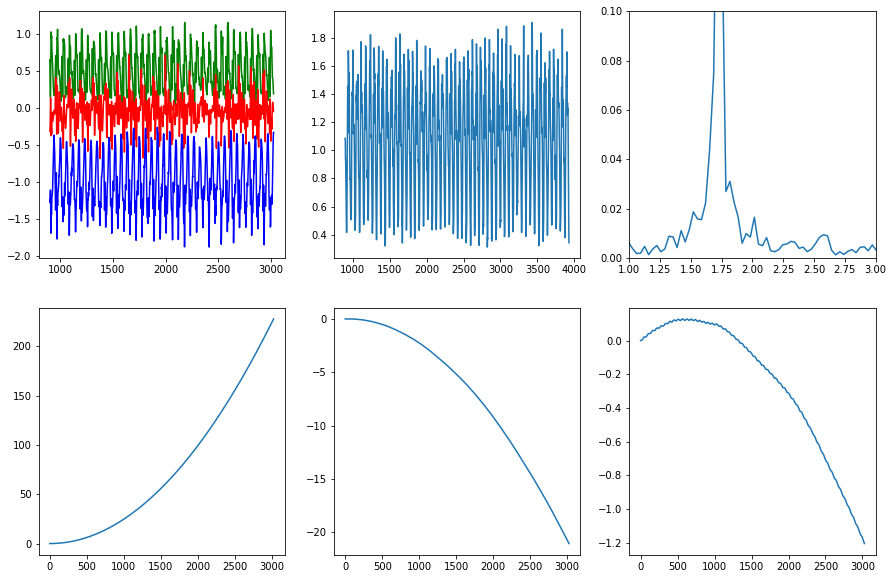

Александр Лишуди - Лишуди_ходьба_1.csv


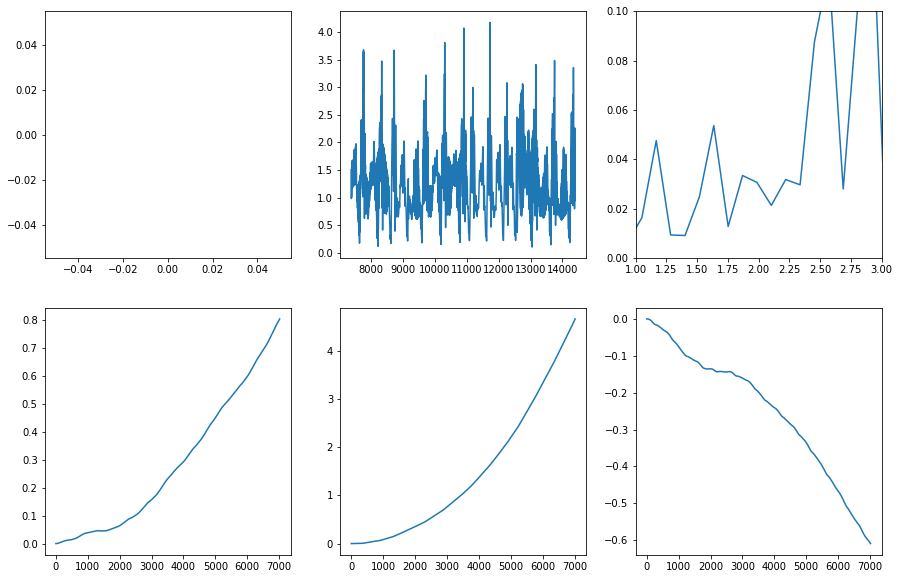

Александр Лишуди - Лишуди_ходьба_2.csv


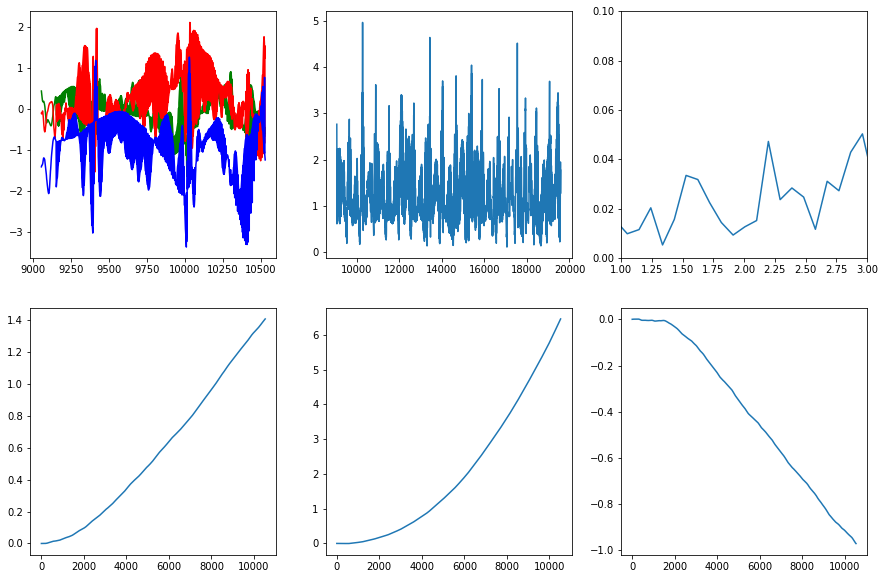

Александр Лишуди - Лишуди_ходьба_3.csv


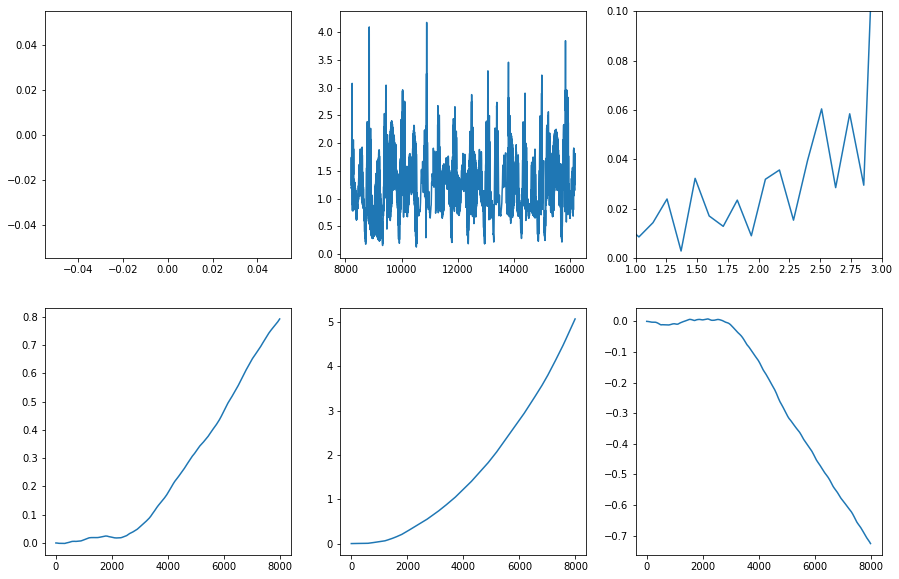

Анастасия Митченко - 2021-07-0413.06.01_Митченко_ходьба.csv


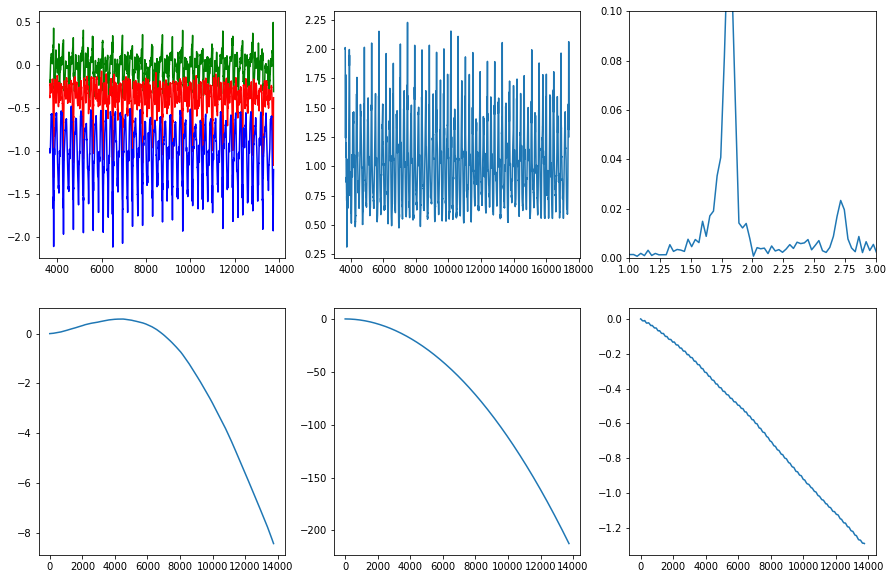

Анастасия Митченко - 2021-07-0413.12.24_Митченко_ходьба.csv


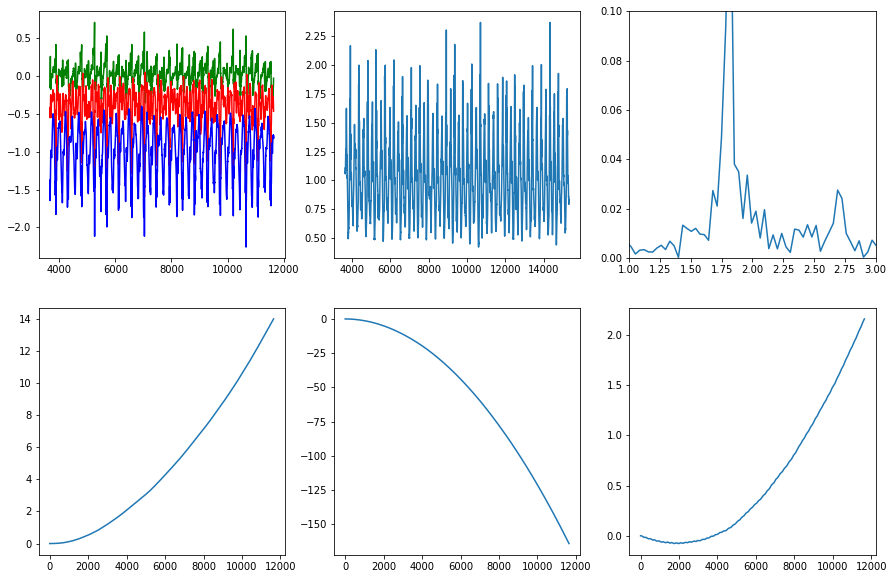

Kirill Dzhunkowski - 2021-07-0420.04.19_Dzhunkowski_лестница


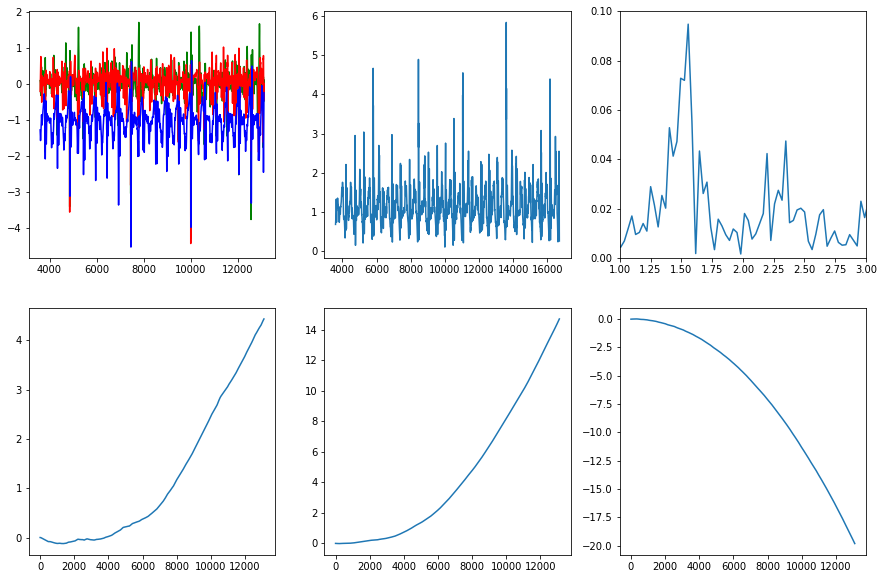

Kirill Dzhunkowski - 2021-07-0719.31.22_Dzhunkowski_лестница.csv


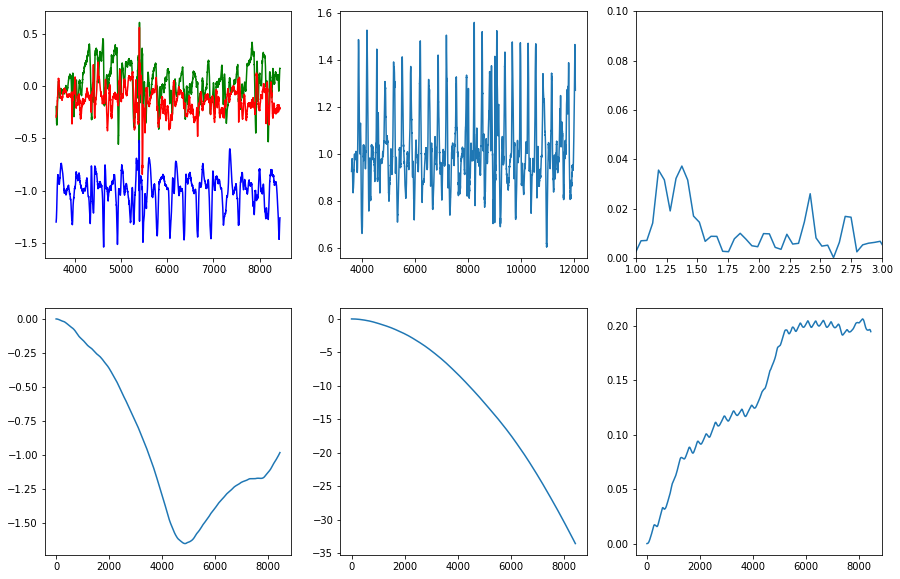

Kirill Dzhunkowski - 2021-07-0719.33.05_Dzhunkowski_лестница.csv


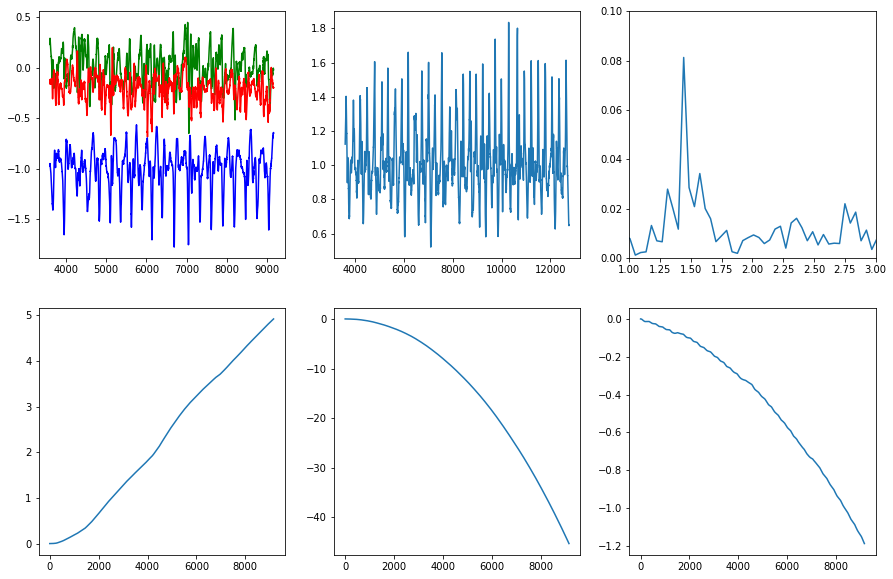

Kirill Dzhunkowski - 2021-07-0719.34.52_Dzhunkowski_лестница.csv


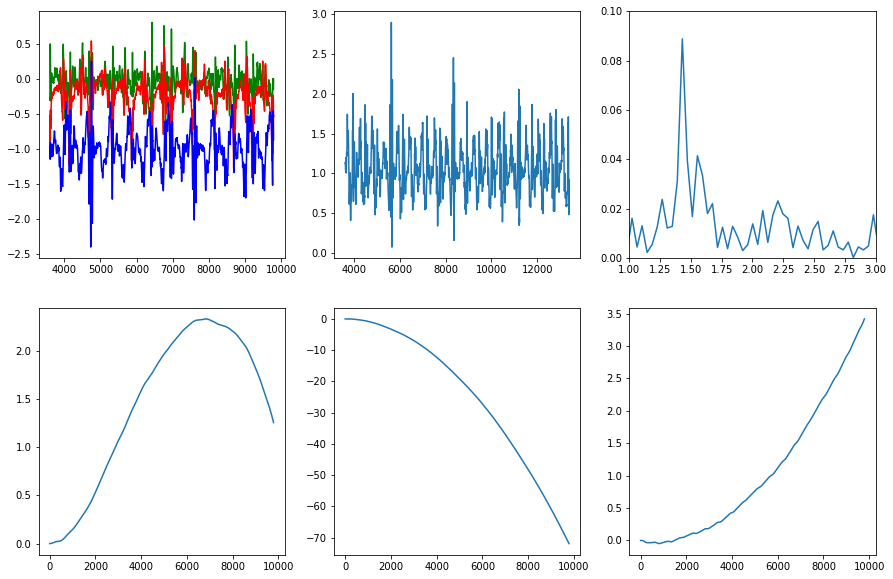

Oleg Petrov - 2021-07-0419.28.25 Петров Лестница


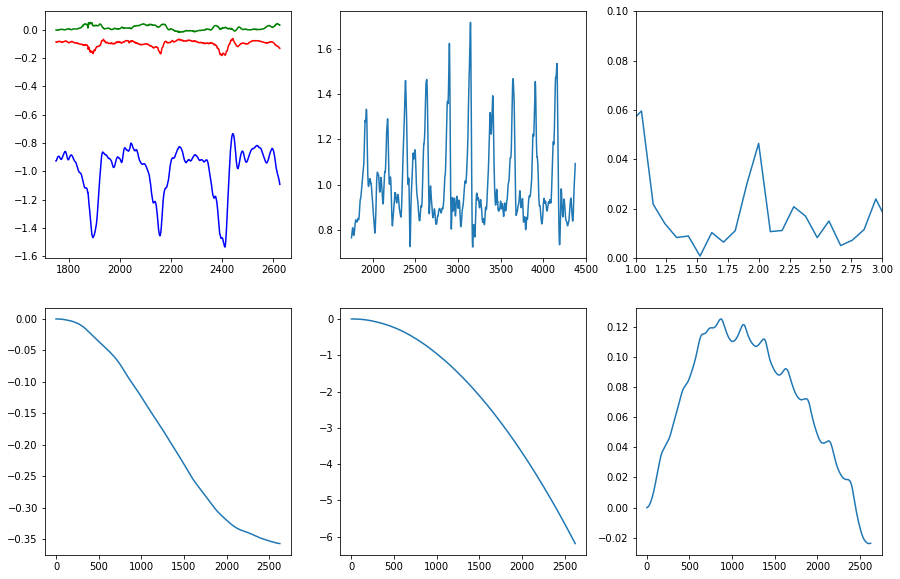

Александр Крупецков - 2021-07-0717.14.42 Крупецков лестница


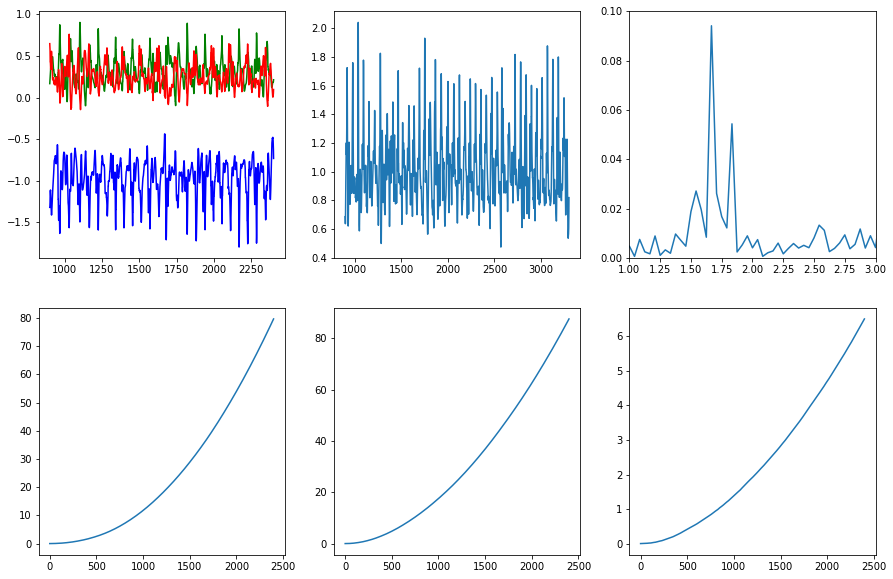

Анастасия Митченко - 2021-07-0616.17.18_Митченко_лестница.csv


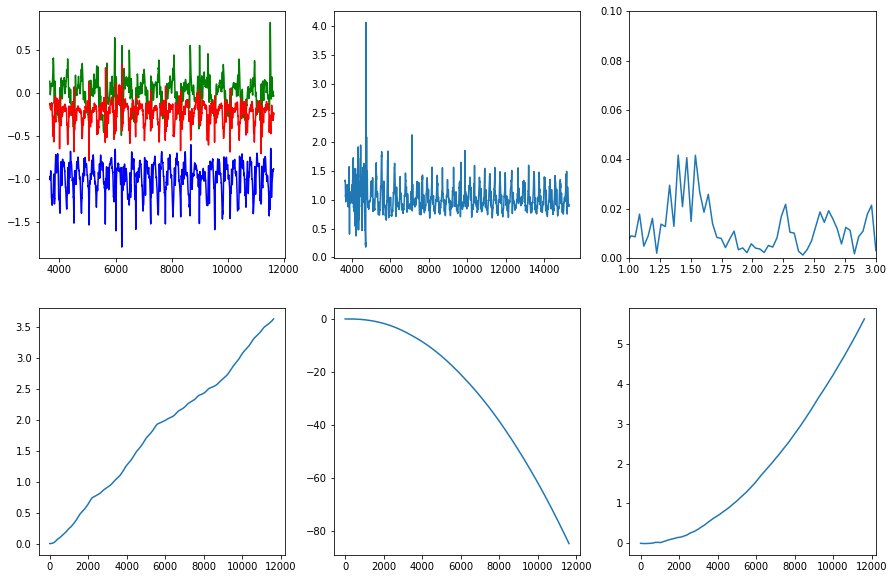

Анастасия Митченко - 2021-07-0616.19.34_Митченко_лестница.csv


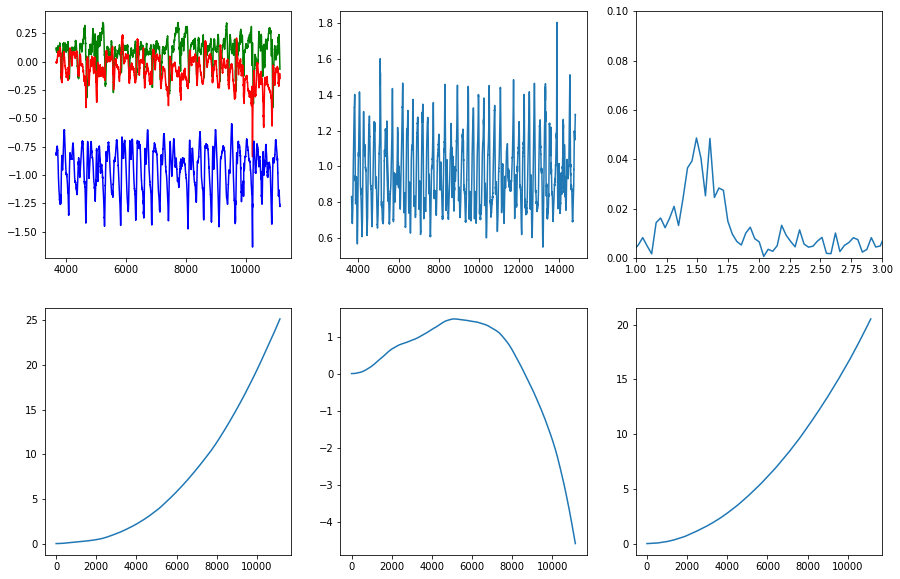

Анастасия Митченко - 2021-07-0616.21.32_Митченко_лестница.csv


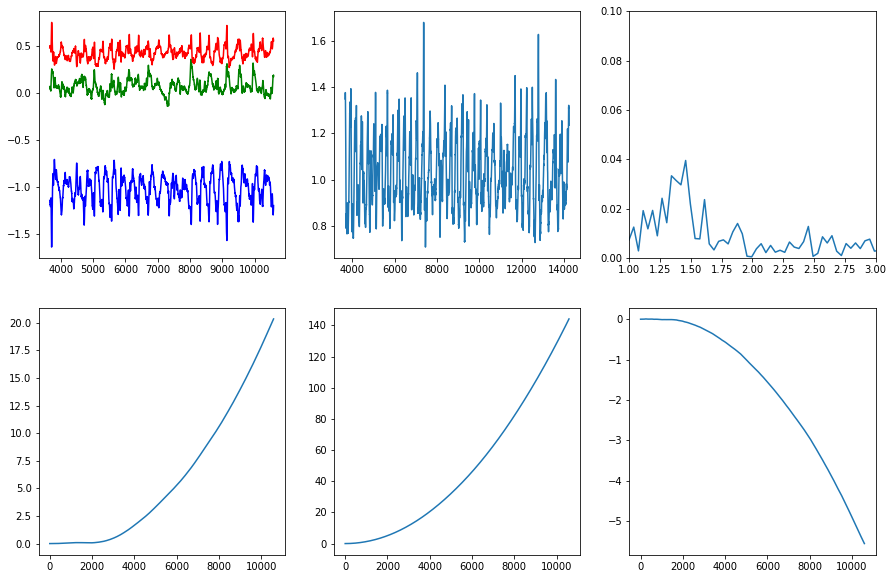

Анастасия Митченко - 2021-07-0616.38.20_Митченко_лестница.csv


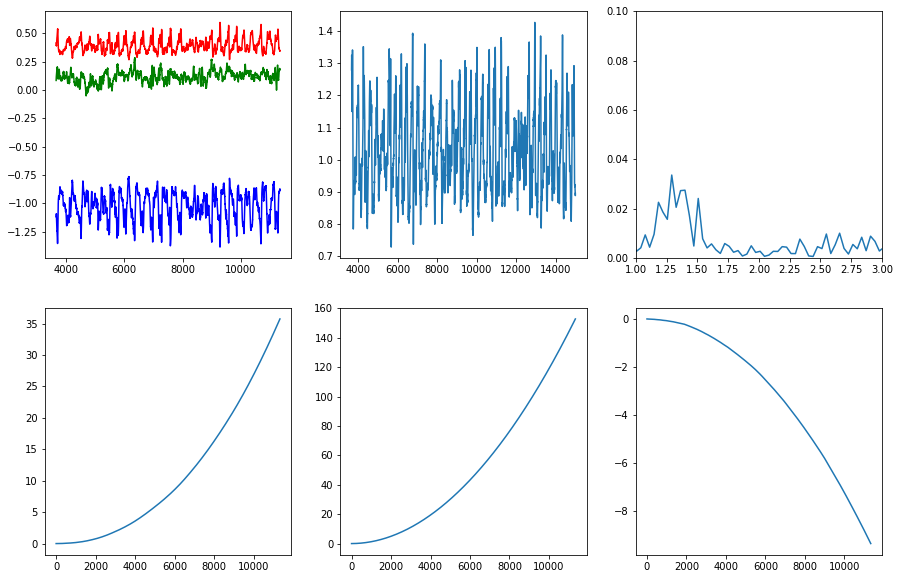

Анатолий Самарский - Самарский_лестница_1.csv


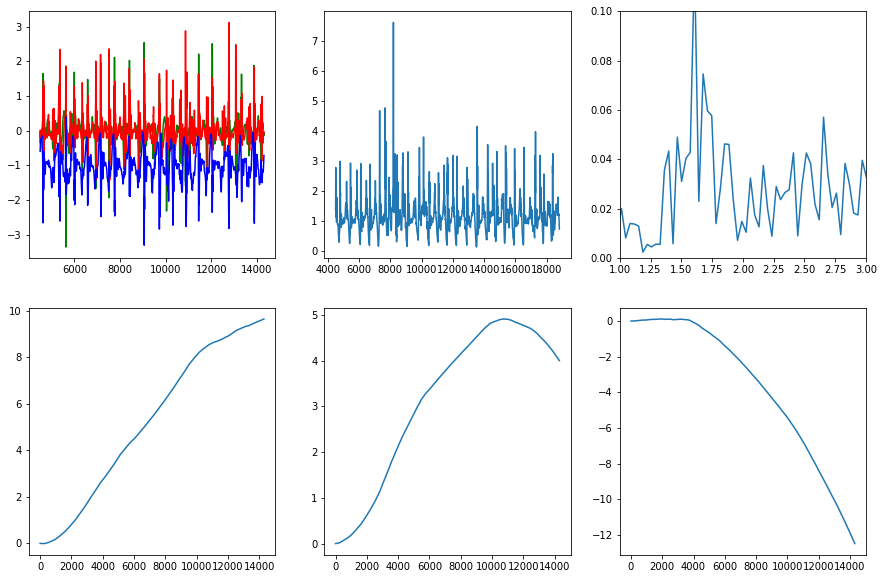

Анатолий Самарский - Самарский_лестница_3.csv


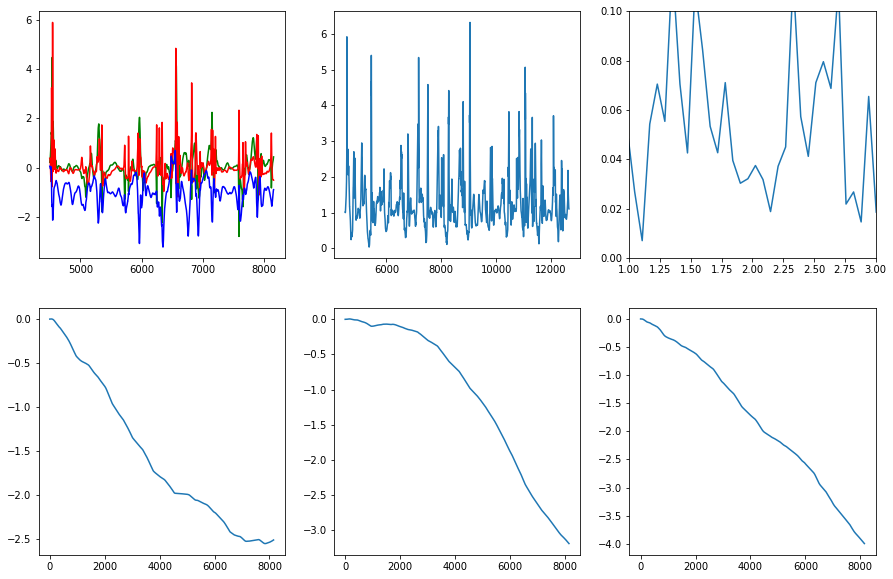

Анатолий Самарский - Самарский_лестница_4.csv


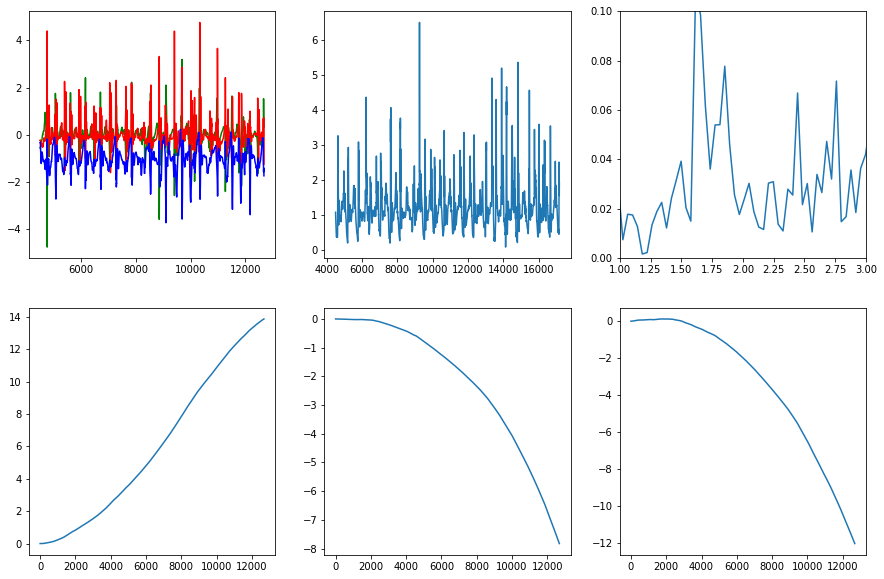

Анатолий Самарский - Самарский_лестница_5.csv


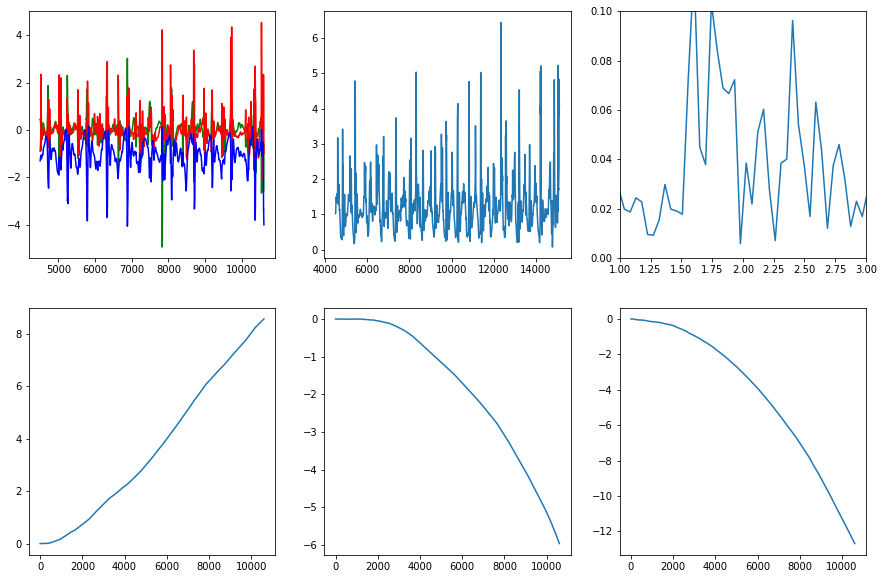

Анна Лисицына - 2021-07-0213.41.41_Лисицына_лестница.csv


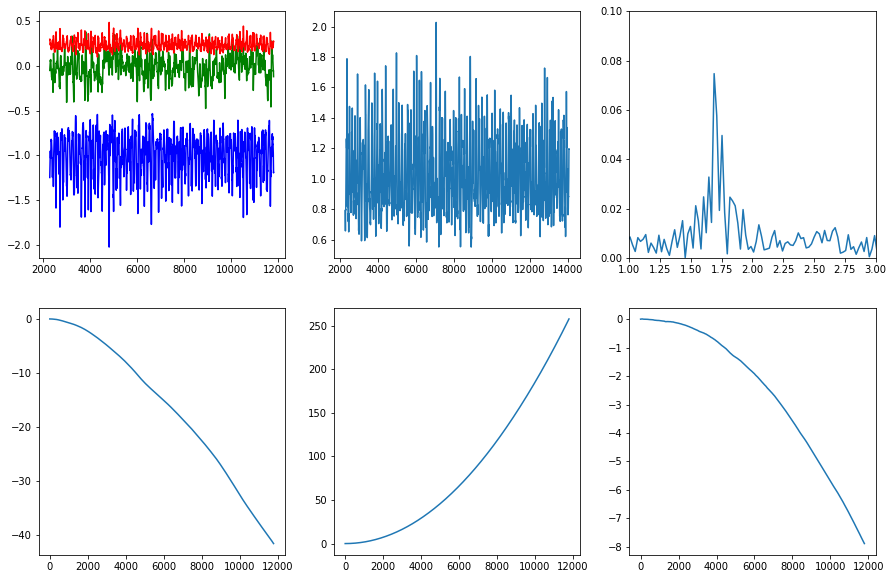

In [461]:
for i in range(1, 5):
    for t in range(min(15, len(types[i]))):
        if i == 1 or i == 4:
            print(types[i][t].Name)
            draw(types[i][t])

In [462]:
DF = pd.DataFrame(columns=['MeanAmpl', 'MinAmpl', 'MaxAmpl',
                           'MeanVar', 'MinVar', 'MaxVar',
                           'YabsN', 'YabsX', 'YabsY', 'YabsZ',
                           'MoveX', 'MoveY', 'MoveZ',
                           'MeanP', 'MinP', 'MaxP'
                          ],
                  index=[i for i in range(9)])

for i in range(9):
    _data = [0, 10000, 0, 0, 10000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000, 0]
    for j in range(len(types[i])):
        if not math.isnan(types[i][j].Ampl):
            _data[0] += types[i][j].Ampl
            _data[1] = min(_data[1], types[i][j].Ampl)
            _data[2] = max(_data[2], types[i][j].Ampl)
        
        if not math.isnan(types[i][j].Var):
            _data[3] += types[i][j].Var
            _data[4] = min(_data[4], types[i][j].Var)
            _data[5] = max(_data[5], types[i][j].Var)
        
        if not math.isnan(max(types[i][j].yabsN[1:])):
            _data[6] += max(types[i][j].yabsN[1:])
        if not math.isnan(max(types[i][j].yabsX[1:])):
            _data[7] += max(types[i][j].yabsX[1:])
        if not math.isnan(max(types[i][j].yabsY[1:])):
            _data[8] += max(types[i][j].yabsY[1:])
        if not math.isnan(max(types[i][j].yabsZ[1:])):
            _data[9] += max(types[i][j].yabsZ[1:])
            
        mx = max(abs(types[i][j].MoveX))
        if not math.isnan(mx):
            _data[10] += mx
        my = max(abs(types[i][j].MoveY))
        if not math.isnan(my):
            _data[11] += my
        mz = max(abs(types[i][j].MoveZ))
        if not math.isnan(mz):
            _data[12] += mz
        
        if not math.isnan(types[i][j].PeakN):
            _data[13] += types[i][j].PeakN
            _data[14] = min(_data[14], types[i][j].PeakN)
            _data[15] = max(_data[15], types[i][j].PeakN)
             
    
    _data[0] /= len(types[i])
    _data[3] /= len(types[i]) 
    _data[6] /= len(types[i])
    _data[7] /= len(types[i])
    _data[8] /= len(types[i]) 
    _data[9] /= len(types[i])
    _data[10] /= len(types[i])
    _data[11] /= len(types[i]) 
    _data[12] /= len(types[i])
    _data[13] /= len(types[i])
     
    DF.iloc[i] = _data
    
DF.to_csv("compare.csv", sep=';')
DF.head(9)

,MeanAmpl,MinAmpl,MaxAmpl,MeanVar,MinVar,MaxVar,YabsN,YabsX,YabsY,YabsZ,MoveX,MoveY,MoveZ,MeanP,MinP,MaxP
0,0.183866,0.005019,3.303566,0.000667,0.000001,0.028676,0.003114,0.009162,0.00991,0.011122,27.586524,79.800093,10.627063,7.739087,0.009725,197.875381
1,2.727335,0.035522,10.496974,0.178307,0.000094,1.323314,0.121787,0.07105,0.09337,0.100519,753.501376,2027.874424,8251.012066,1.7222,0,6.457266
2,7.062211,0.053529,11.707698,1.453206,0.000253,5.887342,0.351097,0.234486,0.36067,0.17665,50.022342,73.721454,75.863493,2.670159,0.019642,6.490201
3,3.050198,0.321819,9.342163,0.096257,0.003676,1.000471,0.03766,0.044241,0.050864,0.043429,458.15787,178.571678,126.175518,3.658632,0.006484,18.321242
4,2.674491,0.064433,12.089345,0.116122,0.000323,1.967201,0.075675,0.049753,0.070822,0.065323,38.622531,98.30006,17.956498,1.456958,0,2.813155
5,0.869948,0.416638,1.561046,0.00687,0.00159,0.027407,0.011172,0.020109,0.023344,0.013863,58.744419,123.712668,3.706207,3.951046,0.015816,12.28604
6,0.376108,0.177841,0.87539,0.001334,0.000199,0.003863,0.005354,0.021931,0.007195,0.015545,136.031271,61.021324,12.323283,2.964441,1.121467,15.542092
7,3.139769,1.506724,5.715747,0.043359,0.015799,0.08081,0.021789,0.019483,0.020685,0.030671,24.643007,72.40305,5.712153,6.124605,4.011717,7.895666
8,0.845344,0.349123,1.243313,0.005678,0.001872,0.009245,0.029242,0.052064,0.09232,0.091226,55.679278,408.383196,212.332824,0.025879,0.019913,0.04183


In [463]:
DF.head(5)

,MeanAmpl,MinAmpl,MaxAmpl,MeanVar,MinVar,MaxVar,YabsN,YabsX,YabsY,YabsZ,MoveX,MoveY,MoveZ,MeanP,MinP,MaxP
0,0.183866,0.005019,3.303566,0.000667,0.000001,0.028676,0.003114,0.009162,0.00991,0.011122,27.586524,79.800093,10.627063,7.739087,0.009725,197.875381
1,2.727335,0.035522,10.496974,0.178307,0.000094,1.323314,0.121787,0.07105,0.09337,0.100519,753.501376,2027.874424,8251.012066,1.7222,0,6.457266
2,7.062211,0.053529,11.707698,1.453206,0.000253,5.887342,0.351097,0.234486,0.36067,0.17665,50.022342,73.721454,75.863493,2.670159,0.019642,6.490201
3,3.050198,0.321819,9.342163,0.096257,0.003676,1.000471,0.03766,0.044241,0.050864,0.043429,458.15787,178.571678,126.175518,3.658632,0.006484,18.321242
4,2.674491,0.064433,12.089345,0.116122,0.000323,1.967201,0.075675,0.049753,0.070822,0.065323,38.622531,98.30006,17.956498,1.456958,0,2.813155


In [464]:
def get_prediction_updated(track):
    
    if track.level == 'base':
        
        # 95%
        if  track.Var < 0.035 and max(track.yabsN[1:]) < 0.016:
            return 0 # Стояние
        
        # 95%
        if track.Ampl > 1 and track.Var > 0.45 and max(track.yabsN) > 0.08:
            return 2 # Бег
        
        if (1.8 < track.Ampl < 5):
            if (1 < track.PeakN < 1.2):
                return 4
            
            if (1.2 < track.PeakN < 1.4):
                if max(abs(track.MoveZ)) > 2 * (max(abs(track.MoveX)) + max(abs(track.MoveY))):
                    return 1 # Ходьба
                if max(abs(track.MoveY)) > max(abs(track.MoveX)) and \
                    max(abs(track.MoveY)) > max(abs(track.MoveZ)):
                    return 4 # Лестница
        
            if (1.4 < track.PeakN < 1.8):
                if max(abs(track.MoveZ)) > 2 * (max(abs(track.MoveX)) + max(abs(track.MoveY))):
                    return 1 # Ходьба
                if max(abs(track.MoveY)) > max(abs(track.MoveX)) and \
                    max(abs(track.MoveY)) > max(abs(track.MoveZ)):
                    return 4 # Лестница
        
            if (1.8 < track.PeakN < 2.7):
                if max(abs(track.MoveY)) > max(abs(track.MoveX)) and \
                    max(abs(track.MoveY)) > max(abs(track.MoveZ)):
                    return 4 # Лестница
                return 1
        
        
        
        # 22%
        #if (1.4 < track.PeakN < 2) or max(abs(track.MoveZ)) > max(abs(track.MoveX)) and \
        #        max(abs(track.MoveZ)) > max(abs(track.MoveY)):
        #    return 1 # Ходьба
        # 68%
        #if (1 < track.PeakN < 1.8) and max(abs(track.MoveY)) > max(abs(track.MoveX)) and \
        #        max(abs(track.MoveY)) > max(abs(track.MoveZ)):
        #    return 4 # Лестница
        
        
        if (1.4 < track.Ampl < 7) and track.Var < 0.25:
            return 3 # Велосипед
            
        return 1

    if track.level == 'advanced':
        # 100%
        if track.Speed > 0.3:
            return 8 # Самокат
        
        if track.Ampl < 1.57:
            if (0.15 < track.Ampl < 0.9) and track.Var < 0.0025:
                # 100%
                if (0.44 < track.Ampl < 0.6) and (0.001829 < track.Var < 0.002):
                    return 5 # Автомобиль
                # 82.5%
                return 6 # Метро
            # 100%
            if 0.4 < track.Ampl and track.Var < 0.03:
                return 5 # Автомобиль
        # 92%
        return 7
    

In [468]:
import random
from sklearn.metrics import accuracy_score

prediction = [get_prediction_updated(track) for track in GoodData]
answer = [parsing(track.Name) for track in GoodData]

Res = pd.DataFrame({'track_num' : np.arange(len(GoodData)), 'answer' : answer, 'action' : prediction})

averange_acc = 0
averange_acc_ = 0
for i in range(500):
    ind_0 = random.sample(Res[Res.answer == 0].index.tolist(), 53)
    ind_1 = random.sample(Res[Res.answer == 1].index.tolist(), 53)
    ind_2 = random.sample(Res[Res.answer == 2].index.tolist(), 53)
    ind_3 = random.sample(Res[Res.answer == 3].index.tolist(), 53)
    ind_4 = random.sample(Res[Res.answer == 4].index.tolist(), 53)
    ind_5 = random.sample(Res[Res.answer == 5].index.tolist(), 35)
    ind_6 = random.sample(Res[Res.answer == 6].index.tolist(), 15)
    ind_7 = random.sample(Res[Res.answer == 7].index.tolist(), 13)
    ind_8 = random.sample(Res[Res.answer == 8].index.tolist(), 8)
    ind_balanced = ind_0 + ind_1 + ind_2 + ind_3 + ind_4 + ind_5 + ind_6 + ind_7 + ind_8
    ind_balanced_ = ind_4

    Res_balanced = Res.iloc[ind_balanced]
    averange_acc += accuracy_score(Res_balanced['answer'], Res_balanced['action'])
    Res_balanced_ = Res.iloc[ind_balanced_]
    averange_acc_ += accuracy_score(Res_balanced_['answer'], Res_balanced_['action'])

print(averange_acc / 5, '%')
# 77.8 %
print(averange_acc_ / 5, '%')

72.53511904761902 %
46.845283018867896 %


### Test Manipulations ###

In [278]:
from datetime import datetime

path = r'C:\Users\Oleg\Desktop\Практика\Айпунбы\test_data' 
data = {}
Data_test = []

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            #print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=';')
                if df.shape[1] == 5:
                    Tr = Track(format(df), dir_entry_path.split("\\")[-1])
                    Data_test.append(Tr)
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            #print(dir_entry_path.split("\\")[-1])
            try:
                df = pd.read_csv(my_file, delimiter=',')
                if df.shape[1] == 5:
                    Tr = Track(format(df), dir_entry_path.split("\\")[-1])
                    Data_test.append(Tr)
            except UnicodeDecodeError:
                print(dir_entry_path.split("\\")[-1])
                pass

In [448]:
Data_ord = [None for i in range(len(Data_test))] 
for track in Data_test:
    track_num = int(track.Name.split('_')[1].split('.')[0]) # важный момент, что треки не по нумерации идут!
    Data_ord[track_num] = track

In [449]:
advanced = ['32', '34', '38', '46', '56', '59', '71', '101', '113', '142', '143']

for track in Data_ord:
    if track.Name[6:][:-4] in advanced:
        track.level = 'advanced'
    else:
        track.level = 'base'

In [450]:
prediction = [get_prediction_updated(track) for track in Data_ord]

Res = pd.DataFrame({'track_num' : np.arange(len(Data_ord)), 'action' : prediction})
Res.to_csv("submit.csv", index=False)
Res.shape

(146, 2)

In [256]:
def get_prediction_updated(track):
    
    if track.level == 'base':
        
        # 94%
        if  track.Var < 0.035 and max(track.yabsN[1:]) < 0.015:
            return 0 # Стояние
        
        # 95%
        if track.Ampl > 1 and track.Var > 0.45 and max(track.yabsN) > 0.08:
            return 2 # Бег
    
        if (1.4 < track.Ampl < 7):
            # 58.6%
            if track.PeakN > 1 and track.PeakN < 2 and abs(track.MoveY[-1]) > max(abs(track.MoveX[-1]), abs(track.MoveZ[-1])):
                return 4 # Лестница
            # 41%
            elif track.PeakN > 1 and track.PeakN < 2:
                return 1 # Ходьба
            
            # 66%
            if track.Var < 0.25:
                return 3 # Велосипед

        return 1
    
####################################################################################

    if track.level == 'advanced':
        # 100%
        if track.Speed > 0.3:
            return 8 # Самокат
        
        if track.Ampl < 1.57:
            if (0.15 < track.Ampl < 0.9) and track.Var < 0.0025:
                # 100%
                if (0.44 < track.Ampl < 0.6) and (0.001829 < track.Var < 0.002):
                   # if 0.0045 < max(track.yabsN):
                        return 5 # Автомобиль
                    #else:
                     #   return 6
                # 82.5%
                return 6 # Метро
            # 100%
            if 0.4 < track.Ampl and track.Var < 0.03:
                return 5 # Автомобиль
        # 92%
        return 7
    